# Assignment 3: Gesture Recognition
Group 2: Jakob Dittrich, David Reiter, Thomas Sickinger, Lea Franz

## Setup

In [59]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.signal import savgol_filter, medfilt, wiener
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

from scipy.signal import savgol_filter, medfilt, wiener
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.metrics import recall_score, precision_score, accuracy_score
from sklearn.metrics import confusion_matrix, f1_score, classification_report
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline

# color for plots
pltcolor = '#002b36'
from warnings import simplefilter
# ignore all future warnings
simplefilter(action='ignore', category=FutureWarning)

### Preprocessed data

In [60]:
number_cols = len(pd.read_csv('gesture_recognition_preprocessed_data.csv', header=None).columns)
names_cols = ['gesture', 'person', 'sample']
for x in range(number_cols - 3):
  names_cols.append("C"+str(x))

In [61]:
df = pd.read_csv('gesture_recognition_preprocessed_data.csv')
# person and sample not relevant at this time because we want to detect gestures
# in general
df.drop(columns=["person", "sample"], inplace=True)
for i in range(1, 21):
    df.rename(columns={"X"+str(i)+".1": "Y"+str(i)}, inplace=True)
    df.rename(columns={"X"+str(i)+".2": "Z"+str(i)}, inplace=True)
df.columns

Index(['gesture', 'X1', 'X2', 'X3', 'X4', 'X5', 'X6', 'X7', 'X8', 'X9', 'X10',
       'X11', 'X12', 'X13', 'X14', 'X15', 'X16', 'X17', 'X18', 'X19', 'X20',
       'Y1', 'Y2', 'Y3', 'Y4', 'Y5', 'Y6', 'Y7', 'Y8', 'Y9', 'Y10', 'Y11',
       'Y12', 'Y13', 'Y14', 'Y15', 'Y16', 'Y17', 'Y18', 'Y19', 'Y20', 'Z1',
       'Z2', 'Z3', 'Z4', 'Z5', 'Z6', 'Z7', 'Z8', 'Z9', 'Z10', 'Z11', 'Z12',
       'Z13', 'Z14', 'Z15', 'Z16', 'Z17', 'Z18', 'Z19', 'Z20'],
      dtype='object')

## Data analysis

In [62]:
gestures = df['gesture'].unique().tolist()
print("There are "+str(len(df))+" samples with "+str(len(gestures))+" kinds of gestures: "+str(gestures))

There are 2160 samples with 8 kinds of gestures: ['left', 'right', 'up', 'down', 'square', 'triangle', 'circleCw', 'circleCcw']


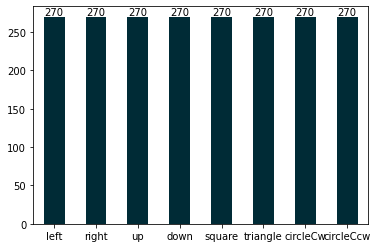

In [63]:
table = df['gesture'].value_counts()
ax = table.plot(kind='bar', rot=0, color=pltcolor);
ax.bar_label(ax.containers[0]);

The plot shows that the classes are balanced and all include 270 samples.

In [64]:
df_corr = df
df_corr.corr().unstack().sort_values().drop_duplicates()

X5   Y6    -0.384871
     Y7    -0.383822
X6   Y7    -0.369919
X4   Y6    -0.355237
Y5   X4    -0.348510
              ...   
X20  X18    0.911329
Z19  Z20    0.916037
X19  X18    0.953333
X20  X19    0.972225
X1   X1     1.000000
Length: 1771, dtype: float64

There are some highly correlated features such as X20 and X19, however there aren't any highly inverse correlated ones.

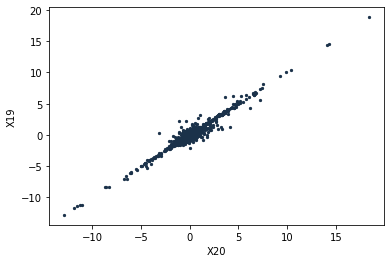

In [65]:
df.plot.scatter("X20", "X19", c="#1b324a", marker='.');

### Visualization of gestures

In [66]:
def visualize_gesture(gesture):
    df_temp = df.loc[df['gesture'] == gesture]
    del df_temp[df_temp.columns[0]]
    df_temp = df_temp.T

    sns.lineplot(df_temp, legend=False).set(
        xticks=range(0, len(df.columns), 10), title=gesture)


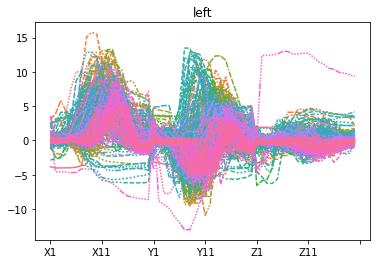

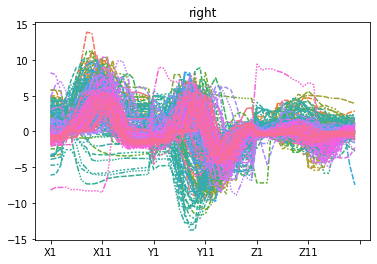

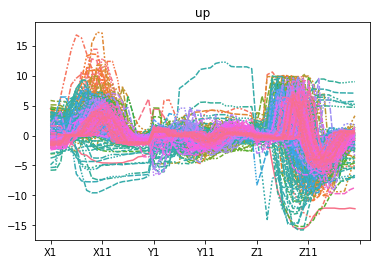

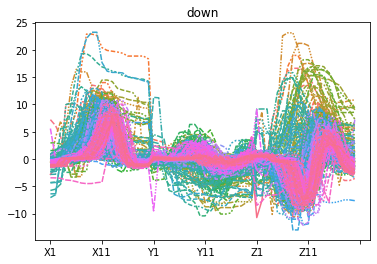

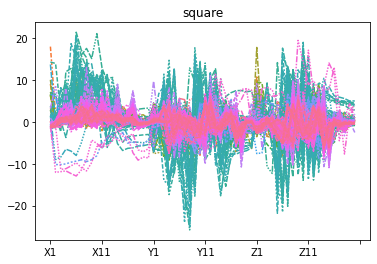

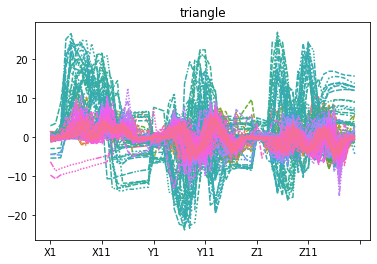

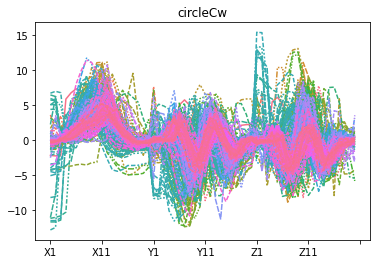

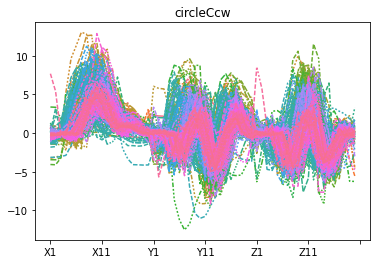

In [67]:
for i, gest in enumerate(gestures):
    plt.figure(i)
    visualize_gesture(gest)

## Preprocessing

## TODO Preprocessing Chain chart/diagram

### Filter

The recorded acceleration should be filtered to reduce noise. Possible options for that are for example a rolling mean, rolling median or the savgol filter as well as other filters from scipy.signal.

TODO: remove -> Recorded acceleration should probably be filtered to reduce noise. The
rolling function of pandas can help here. Consider e.g. running mean,
running median, or SV filters. Hint: you probably need to apply a stronger
filter than would seem intuitive at the beginning. Think about which info
needs to remain in the task - it might be less that you would intuitively
guess. Check that you still have the required information in the data after
filtering (e.g. using plots). Again, try to use vectorized commands.

# TODO: choose and run only 1 of the filters -> rolling mean and median create NaN values atm

In [68]:
df_no_gesture = df.iloc[: , 1:]

In [69]:
# rolling mean -> NaN values
#df_filter = df_no_gesture.apply(func=lambda x: pd.Series(x).rolling(5).mean())

In [70]:
# rolling median -> NaN values
#df_filter = df_no_gesture.apply(func=lambda x: pd.Series(x).rolling(5).median())


In [71]:
# scipy savgol -> looks kinda similar
df_filter = df_no_gesture.apply(func=lambda x: savgol_filter(x, 5, 2))


In [72]:
# scipy medfilt: median filter to the input array -> looks kinda similar to original
#df_filter = df_no_gesture.apply(func=lambda x: medfilt(x))


In [73]:
# scipy wiener -> looks really bad
#df_filter = df_no_gesture.apply(func=lambda x: wiener(x))

In [74]:
df_filter.isnull().values.ravel().sum()

0

In [75]:
df_filter.insert(loc=0, column='gesture', value=df['gesture'].to_numpy())
df = df_filter
#df.dropna() # for rolling mean or median

The filter XY has proven to be the best option .. for the data as the gestures seem well distinguishable.

The filter with rolling mean and medium produced NaN values and therefore the number of samples would be reduced.

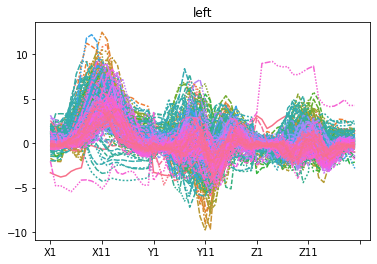

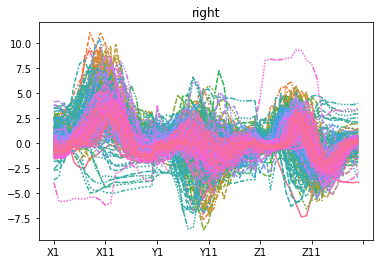

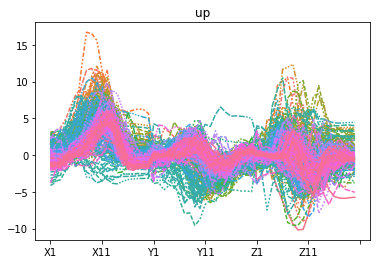

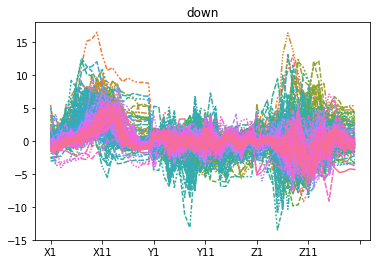

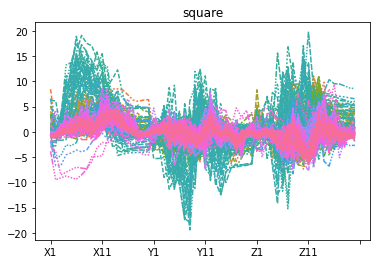

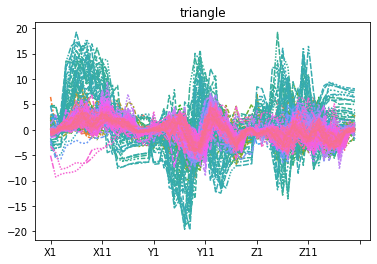

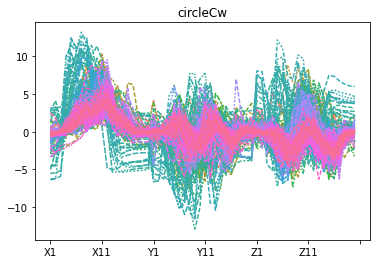

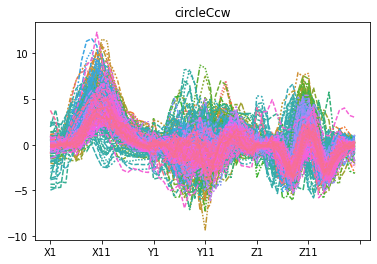

In [76]:
for i, gest in enumerate(gestures):
    plt.figure(i)
    visualize_gesture(gest)

### Features

#### Interpolation - really needed?

In [77]:
# really needed? - preprocessed file has same length?

• If you plan on using acceleration values themselves as features, different
lengths of recordings are going to be problematic. You can interpolate series to uniform length . Again, try to use vectorized commands. Be aware
that with interpolation to a uniform amount of features you also lose the
implicit information of how long the recording was (which was expressed
by the amount of samples before). The length of the original recording
can therefore become a numeric feature itself. Hint: you probably need
less interpolated acceleration values than you would expect. Usually, human body motion can produce up to a max of about 20Hz of movement
frequencies, so using e.g. 100Hz recordings does not necessarily add any
information you can use. And the important acceleration information to
distinguish gestures is likely well below 20Hz, so a couple of values per
gestures probably already do the job.

Acceleration values of all axes can be used directly as one sample (concatenate all axis into one row).

#### Original length of recording as features

The length of the original recording should be added as a feature. The original data is available in the raw data files for each axis.

In [78]:
raw_x = pd.read_csv('raw_data_wear_x.csv', header=None)
raw_y = pd.read_csv('raw_data_wear_y.csv', header=None)
raw_z = pd.read_csv('raw_data_wear_z.csv', header=None)
print('Number of columns in raw data files: x='+str(len(raw_x.columns)) +
      ", y="+str(len(raw_y.columns))+", z="+str(len(raw_z.columns)))


Number of columns in raw data files: x=427, y=427, z=427


As all raw data files include the same number of columns, the length of the recordings are taken from raw_data_wear_x. The columns for gesture, person and sample are not relevant for the recording length and therefore removed from the count.

In [79]:
df["recording_length"] = raw_x.count(axis='columns')-3

### Outliers

The outliers were set to the lower or upper limit instead of removing them to keep more information and improve the model performance.

In [80]:
cols = df.columns.tolist()
cols.remove('gesture')

for col in cols:
    q25 = df[col].quantile(0.25)
    q75 = df[col].quantile(0.75)
    intr_qr = q75-q25

    q_hi = q75+(1.5*intr_qr)
    q_low = q25-(1.5*intr_qr)

    df.loc[df[col] < q_low, col] = q_low
    df.loc[df[col] > q_hi, col] = q_hi
    df_filtered = df[(df[col] < q_hi) & (df[col] > q_low)]

print(str(len(df)-len(df_filtered)) +
      ' rows with outliers detected. Outliers were set to the lower or upper limit.')

28 rows with outliers detected. Outliers were set to the lower or upper limit.


### Scaling

The data gets scaled with the StandardScaler to change the distribution by which removing the mean and scaling each feature to unit variance.

In [81]:
# uniformly scale data
scaler = StandardScaler()
y_gestures = df['gesture']
X_transform = scaler.fit_transform(df.iloc[:, 1:].values)


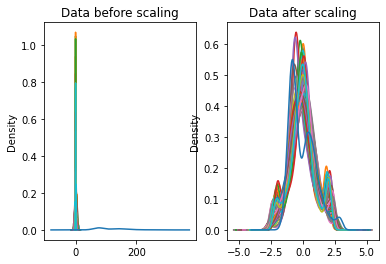

In [82]:
fig, (ax1, ax2) = plt.subplots(ncols=2)
ax1.set_title("Data before scaling")
ax2.set_title("Data after scaling")

df.plot.density(ax=ax1, legend=False)
df_scaled = pd.DataFrame(X_transform, columns=df.iloc[:, 1:].columns)
df_scaled.plot.density(ax=ax2, legend=False);
df = df_scaled
df.insert(loc=0, column='gesture', value=y_gestures)

### Other features

In [83]:
x_data = df.iloc[:, 1:21]
y_data = df.iloc[:, 21:41]
z_data = df.iloc[:, 41:61]

axis_data = [{"name": "x", "data": x_data}, {
    "name": "y", "data": y_data}, {"name": "z", "data": z_data}]

#### Magnitude for each step

In [84]:
mag_data = pd.DataFrame()
for i in range(20):
    mag_list = []
    for j in range(len(x_data)):
        x = x_data.iloc[j].values[i]
        y = y_data.iloc[j].values[i]
        z = z_data.iloc[j].values[i]
        mag_list.append(np.sqrt(x**2 + y**2 + z**2))
    mag_data["MAG"+str(i+1)] = mag_list

#### Mean Magnitude

In [85]:
df['mean_mag'] = mag_data.mean(axis=1)

#### Minimum Magnitude

In [86]:
df['min_mag'] = mag_data.min(axis=1)

#### Maximum Magnitude

In [87]:
df['max_mag'] = mag_data.max(axis=1)

#### Range of Magnitude

In [88]:
df['max_mag'] = abs(mag_data.max(axis=1) - mag_data.min(axis=1))

#### Mean of the acceleration data

In [89]:
mean_x = df.iloc[:, 1:21].mean(axis=1)
mean_y = df.iloc[:, 21:41].mean(axis=1)
mean_z = df.iloc[:, 41:61].mean(axis=1)
df['mean_x'] = mean_x
df['mean_y'] = mean_y
df['mean_z'] = mean_z

#### Mean Absolute Deviation of the acceleration data

In [90]:
df['mad_x'] = df.iloc[:, 1:21].mad(axis=1)
df['mad_y'] = df.iloc[:, 21:41].mad(axis=1)
df['mad_z'] = df.iloc[:, 41:61].mad(axis=1)

#### Root Mean Square of the acceleration data

In [91]:
df['rms_x'] = df.iloc[:, 1:21].apply(func=lambda x: np.sqrt(np.mean(x**2)), axis=1)
df['rms_y'] = df.iloc[:, 21:41].apply(func=lambda x: np.sqrt(np.mean(x**2)), axis=1)
df['rms_z'] = df.iloc[:, 31:61].apply(func=lambda x: np.sqrt(np.mean(x**2)), axis=1)

##### Variance features

In [92]:
for axis in axis_data:
    variance_arr = axis.get('data').var(axis=1)
    df['variance_'+axis.get('name')] = variance_arr

df['mean_variance'] = df.iloc[:,-3:].mean(axis=1)


##### Standard deviation features

In [93]:
for axis in axis_data:
    sd_arr = axis.get('data').var(axis=1)
    df['sd_'+axis.get('name')] = sd_arr

df['mean_sd'] = df.iloc[:,-3:].mean(axis=1)
df['mag_sd'] = mag_data.var(axis=1)

#### Peaks
The times the acceleration data went over the mean of the axis

In [94]:
mean_x = df.iloc[:, 1:21].mean(axis=1)
mean_y = df.iloc[:, 21:41].mean(axis=1)
mean_z = df.iloc[:, 41:61].mean(axis=1)

x = df.iloc[:, 1:21].T
y = df.iloc[:, 21:41].T
z = df.iloc[:, 41:61].T

df['peaks_x'] = x[x > mean_x].count()
df['peaks_y'] = y[y > mean_y].count()
df['peaks_z'] = z[z > mean_z].count()

df['peaks_mag'] = mag_data[mag_data > df['mean_mag']].count(axis=1)

#### Frequency power and phase

#### Autocorrelation of acceleration values

#### Wavelet components

https://hcis-journal.springeropen.com/articles/10.1186/s13673-017-0097-2

https://ataspinar.com/2018/04/04/machine-learning-with-signal-processing-techniques/

Feature extraction is not limited to those discussed in the lecture. But for
a start:
– Frequency power and phase
– Autocorrelation of acceleration values
– Wavelet components
– All of the above can be applied on the integrations of acceleration as
well (position <–> speed <–> acceleration).

### PCA

This plot shows the explained variance ratio when X% of variance is kept. X% was chosen because otherwise the model performance would decrease too much.
Feature reduction with PCA wil be applied later when training the models using a pipeline.

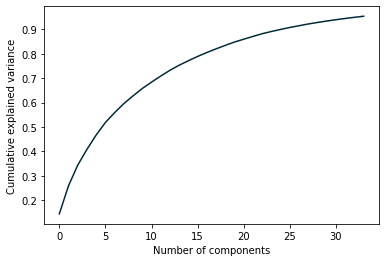

In [95]:
pca = PCA(n_components=0.95)
X_pca = pca.fit(X_transform)
plt.plot(np.cumsum(pca.explained_variance_ratio_), color=pltcolor)
plt.xlabel('Number of components')
plt.ylabel('Cumulative explained variance')
plt.show()

PCA with X% variance means Y components in this case.

In [96]:
X_pca = pca.transform(X_transform)
X_pca.shape

(2160, 34)

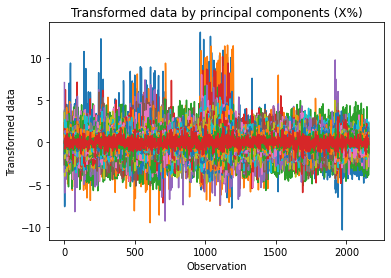

In [97]:
plt.plot(X_pca)
plt.xlabel('Observation')
plt.ylabel('Transformed data')
plt.title('Transformed data by principal components (X%)');

# Models

In [98]:
# split dataset in train and test data
X = df.values[:,1:]
Y = df.values[:,0:1]

X_train, X_test, y_train, y_test = train_test_split(
    X, y_gestures, test_size=0.2)

In [99]:
def print_model_result(predicted_labels):
    print("Recall: ", recall_score(y_test, predicted_labels, average=None))
    print("Recall Average: ", recall_score(
        y_test, predicted_labels, average="micro"))
    print("Precision: ", precision_score(
        y_test, predicted_labels, average=None))
    print("Precision Average: ", precision_score(
        y_test, predicted_labels, average="micro"))
    print("F1-Score: ", f1_score(y_test, predicted_labels, average=None))
    print("Accuracy: %.2f  ," % accuracy_score(y_test, predicted_labels,
          normalize=True), accuracy_score(y_test, predicted_labels, normalize=False))

    print("Number of samples:", y_test.shape[0])
    ConfusionMatrixDisplay(confusion_matrix(
        y_test, predicted_labels), display_labels=gestures).plot(cmap="Blues")

### KNN

In [100]:
knn_hyperparameters = list(range(1, 31))

In [101]:
knn = KNeighborsClassifier()
param_grid = dict(n_neighbors=knn_hyperparameters)

# defining parameter range
grid = GridSearchCV(KNeighborsClassifier(), param_grid, cv=10,
                    scoring='accuracy',
                    return_train_score=False, verbose=1, n_jobs=-1)

# fitting the model for grid search
grid_search = grid.fit(X_train, y_train)


Fitting 10 folds for each of 30 candidates, totalling 300 fits


In [102]:
accuracy = grid_search.best_score_ * 100
print("Best params: "+str(grid_search.best_params_))
print("Accuracy for our training dataset with tuning is : {:.2f}%"\
    .format(accuracy))

Best params: {'n_neighbors': 8}
Accuracy for our training dataset with tuning is : 82.35%


Recall:  [0.91176471 0.8627451  0.85714286 0.89583333 0.8        0.77358491
 0.92592593 0.67346939]
Recall Average:  0.8402777777777778
Precision:  [0.86111111 0.75862069 0.89361702 0.76785714 0.78688525 0.97619048
 0.92592593 0.78571429]
Precision Average:  0.8402777777777778
F1-Score:  [0.88571429 0.80733945 0.875      0.82692308 0.79338843 0.86315789
 0.92592593 0.72527473]
Accuracy: 0.84  , 363
Number of samples: 432


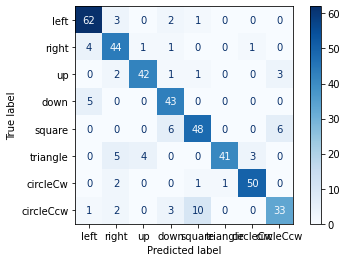

In [103]:
predicted_labels = grid_search.best_estimator_.predict(X_test)
predicted_labels_knn = predicted_labels

best_knn_model = grid_search.best_estimator_
gs_knn = grid_search

print_model_result(predicted_labels)

### Random Forest

In [104]:
tuning_params_rf = {
    'max_depth': [30, 40, 50, 60],
    'max_features': ['sqrt'],
    'min_samples_leaf': [1, 2, 4],
    'min_samples_split': [2, 5, 10],
    'n_estimators': [200, 400, 600]}


param_grid_rf = {}

for key, value in tuning_params_rf.items():
    hyperparam_key = "classify__" + key
    param_grid_rf[hyperparam_key] = value

In [105]:
gs = GridSearchCV(RandomForestClassifier(), param_grid=tuning_params_rf,
                  cv=10, scoring="accuracy", n_jobs=-1)
gs.fit(X_train, y_train);

In [106]:
print('Best parameters: '+str(gs.best_params_))
print('Best accuracy score: '+str(gs.best_score_))
print('Importances of the features: ', gs.best_estimator_.feature_importances_)

Best parameters: {'max_depth': 40, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 600}
Best accuracy score: 0.8773289420621051
Importances of the features:  [0.0067608  0.00697919 0.00593695 0.00698923 0.00539845 0.00802165
 0.00633438 0.00618471 0.01123709 0.01070501 0.00802894 0.00811253
 0.00850546 0.00679802 0.00896137 0.01037173 0.00810238 0.01095168
 0.00751488 0.00589646 0.00462191 0.00557682 0.00857726 0.005225
 0.01399941 0.01056248 0.00837282 0.0135456  0.02144269 0.01111469
 0.0069709  0.0235532  0.02429803 0.01624372 0.01982387 0.03009445
 0.03441916 0.02048803 0.00561056 0.00539287 0.0073348  0.00469132
 0.00490001 0.00613368 0.01428047 0.02039481 0.01705657 0.0117221
 0.00780215 0.01442029 0.01476711 0.01186196 0.02518008 0.02388568
 0.01900417 0.02731603 0.01901456 0.00528578 0.00566163 0.00630033
 0.08844732 0.00826342 0.00477845 0.00395388 0.00751658 0.0058414
 0.00559529 0.00553095 0.01000076 0.0212561  0.00825553 0.00813408
 0.

**X most important features**


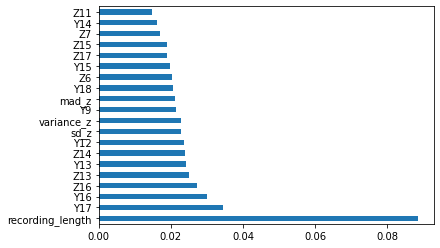

In [107]:
feature_importances = pd.Series(gs.best_estimator_.feature_importances_, index=df.iloc[:, 1:].columns)
feature_importances.nlargest(20).plot(kind='barh');

Recall:  [0.88235294 0.84313725 0.91836735 0.91666667 0.75       0.98113208
 0.88888889 0.7755102 ]
Recall Average:  0.8680555555555556
Precision:  [0.90909091 0.84313725 0.88235294 0.88       0.9        0.85245902
 0.94117647 0.73076923]
Precision Average:  0.8680555555555556
F1-Score:  [0.89552239 0.84313725 0.9        0.89795918 0.81818182 0.9122807
 0.91428571 0.75247525]
Accuracy: 0.87  , 375
Number of samples: 432


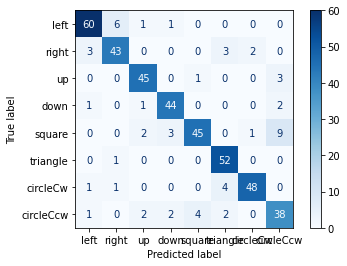

In [108]:
predicted_labels = gs.best_estimator_.predict(X_test)

best_rf_model = grid_search.best_estimator_
predicted_labels_rf = predicted_labels
gs_rf = gs

print_model_result(predicted_labels)

### SVM

In [109]:
tuning_params_svm = {"C": [0.001, 0.01, 0.1, 1, 10],
                     "gamma": [0.001, 0.01, 0.1, 1, 10], "kernel": ['rbf']}
param_grid_svm = {}

for key, value in tuning_params_svm.items():
    hyperparam_key = "classify__" + key
    param_grid_svm[hyperparam_key] = value


In [110]:
gs = GridSearchCV(SVC(), param_grid=tuning_params_svm,
                  cv=10, scoring="accuracy", n_jobs=-1)
gs.fit(X_train, y_train)

GridSearchCV(cv=10, estimator=SVC(), n_jobs=-1,
             param_grid={'C': [0.001, 0.01, 0.1, 1, 10],
                         'gamma': [0.001, 0.01, 0.1, 1, 10],
                         'kernel': ['rbf']},
             scoring='accuracy')

In [111]:
print('Best parameters: '+str(gs.best_params_))
print('Best accuracy score: '+str(gs.best_score_))

Best parameters: {'C': 10, 'gamma': 0.01, 'kernel': 'rbf'}
Best accuracy score: 0.9085360935609625


Recall:  [0.92647059 0.94117647 0.93877551 0.91666667 0.9        0.9245283
 0.92592593 0.81632653]
Recall Average:  0.9120370370370371
Precision:  [0.92647059 0.90566038 0.9787234  0.91666667 0.81818182 0.96078431
 0.94339623 0.86956522]
Precision Average:  0.9120370370370371
F1-Score:  [0.92647059 0.92307692 0.95833333 0.91666667 0.85714286 0.94230769
 0.93457944 0.84210526]
Accuracy: 0.91  , 394
Number of samples: 432


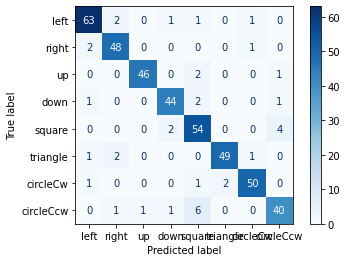

In [112]:
predicted_labels = gs.best_estimator_.predict(X_test)
predicted_labels_svm = predicted_labels
gs_svm = gs

best_svm_model = gs.best_estimator_

print_model_result(predicted_labels)

### PCA

In [113]:
# Initialze the estimators
clf1 = KNeighborsClassifier()
clf2 = RandomForestClassifier()
clf3 = SVC()

In [114]:
# hyperparameters for each dictionary
param1 = {}
param1['classifier__n_neighbors'] = knn_hyperparameters
param1['classifier'] = [clf1]

param2 = {}
param2['classifier__max_depth'] = tuning_params_rf.get('max_depth')
param2['classifier__max_features'] = tuning_params_rf.get('max_features')
param2['classifier__min_samples_leaf'] = tuning_params_rf.get(
    'min_samples_leaf')
param2['classifier__min_samples_split'] = tuning_params_rf.get(
    'min_samples_split')
param2['classifier__n_estimators'] = tuning_params_rf.get('n_estimators')
param2['classifier'] = [clf2]

param3 = {}
param3['classifier__C'] = tuning_params_svm.get('C')
param3['classifier__gamma'] = tuning_params_svm.get('gamma')
param3['classifier__kernel'] = tuning_params_svm.get('kernel')
param3['classifier'] = [clf3]

In [115]:
pipe = Pipeline([
    ('normalization', StandardScaler()),
    ('pca', PCA(n_components=0.95)),
    ('classifier', clf1)
])
params = [param1, param2, param3]

In [116]:
# pca grid search
gs_pca = GridSearchCV(pipe, params, cv=10, n_jobs=-1,
                      scoring='accuracy').fit(X_train, y_train)

In [117]:
print('Best classifier and parameters: '+str(gs_pca.best_params_))
print('Best accuracy score: '+str(gs_pca.best_score_))
print('Best estimator explained variance: ' +
      str(gs_pca.best_estimator_.steps[1][1].explained_variance_))

Best classifier and parameters: {'classifier': SVC(C=10, gamma=0.01), 'classifier__C': 10, 'classifier__gamma': 0.01, 'classifier__kernel': 'rbf'}
Best accuracy score: 0.9091242102433122
Best estimator explained variance: [16.74219356  8.46623349  5.87959492  5.4174432   4.4544654   3.37291035
  3.31483542  2.53044335  2.27872711  2.07862115  1.91627067  1.82779315
  1.61825587  1.53304387  1.45829192  1.36444505  1.27228926  1.17328992
  1.084925    1.07655254  1.02077684  0.99114529  0.88528909  0.83097908
  0.79869763  0.74068678  0.72071799  0.70554163  0.67274539  0.62189102
  0.55295619  0.50629473  0.49499871  0.459615    0.4286845   0.41872317
  0.39615609  0.34036074  0.32775633  0.30127368]


Recall:  [0.94117647 0.96078431 0.93877551 0.91666667 0.9        0.94339623
 0.92592593 0.87755102]
Recall Average:  0.9259259259259259
Precision:  [0.91428571 0.94230769 0.93877551 0.91666667 0.87096774 0.96153846
 0.94339623 0.93478261]
Precision Average:  0.9259259259259259
F1-Score:  [0.92753623 0.95145631 0.93877551 0.91666667 0.8852459  0.95238095
 0.93457944 0.90526316]
Accuracy: 0.93  , 400
Number of samples: 432


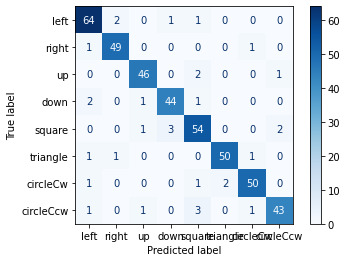

In [118]:
predicted_labels_pca = gs_pca.best_estimator_.predict(X_test)
best_pca_model = gs_pca.best_estimator_
print_model_result(predicted_labels_pca)

Do a gallery dependent data partitioning and train models using
cross validation. Compare different models and feature extraction approaches by their cross validation results, and for the selected “best”
model show at least the confusion matrix for held-back test partition over different gestures. Discuss what the best feature extraction/model configuration is you found, and if there are gestures that
are harder to distinguish than others.


– **Bonus objective**: do gallery independent data partitioning instead
using leave subject out cross validation (LSOCV, see slides).

Paper: KNN, J48 tree, random forest, bagging with 10 fold CV with 10 repetitions and leave-on-subject-out cross validation

## Final Result

### Model comparison

In [119]:
model_names = [
    'KNN',
    'Random Forest',
    'SVM',
    'PCA SVM'
]

#### Best score after training

In [120]:
model_gs = [
    gs_knn,
    gs_rf,
    gs_svm,
    gs_pca
]

for i, model in enumerate(model_gs):
    print(model_names[i]+": Best accuracy: "+str(model.best_score_))


KNN: Best accuracy: 0.823511224626966
Random Forest: Best accuracy: 0.8773289420621051
SVM: Best accuracy: 0.9085360935609625
PCA SVM: Best accuracy: 0.9091242102433122


#### Model evaluation with the best hyperparameters

In [121]:
best_model_predictions = [
    predicted_labels_knn,
    predicted_labels_rf,
    predicted_labels_svm,
    predicted_labels_pca
]

for i, pred in enumerate(best_model_predictions):
    print(model_names[i])
    print(classification_report(y_test, pred))


KNN
              precision    recall  f1-score   support

   circleCcw       0.86      0.91      0.89        68
    circleCw       0.76      0.86      0.81        51
        down       0.89      0.86      0.88        49
        left       0.77      0.90      0.83        48
       right       0.79      0.80      0.79        60
      square       0.98      0.77      0.86        53
    triangle       0.93      0.93      0.93        54
          up       0.79      0.67      0.73        49

    accuracy                           0.84       432
   macro avg       0.84      0.84      0.84       432
weighted avg       0.85      0.84      0.84       432

Random Forest
              precision    recall  f1-score   support

   circleCcw       0.91      0.88      0.90        68
    circleCw       0.84      0.84      0.84        51
        down       0.88      0.92      0.90        49
        left       0.88      0.92      0.90        48
       right       0.90      0.75      0.82        60
      

### Final decision

#### Gestures in final model

or the selected “best”
model show at least the confusion matrix for held-back test partition over different gestures. Discuss what the best feature extraction/model configuration is you found, and if there are gestures that
are harder to distinguish than others

In [122]:
# print classification report/confusion matrix of the models showing all the gestures
